# Home Credit Risk

## Objetivo 
El principal objetivo de esta competencia de Data Science es desarrollar un modelo predictivo que identifique de manera eficaz a los clientes con una alta probabilidad de incumplimiento en sus obligaciones de pago de deudas. Esta herramienta de predicción debe no solo ser precisa en el corto plazo, sino también mostrar una estabilidad y fiabilidad a largo plazo.

### Requisitos (puntos a cumplir)
 - Que sea preciso y confiable
 - Estable a largo plazo
    - Sostenible que el modelo se ajuste conforme a las condiciones sin comprometer eficacia. 
        
### Requisitos
- Que no se use internet(el notebook)
- CPU y GPU <= 12 horas de tiempo de corrida
- Se puede usar información externa (modelos pre entrenados)
- Se entrega en un archivo llamado "submission.csv"

## Evaluación

1. Innovación - 40%: Analiza la estabilidad crediticia a lo largo del tiempo, centrándose específicamente en la métrica de evaluación de la competencia más allá de la simple selección de características. p.ej. Gini medio elevado, rendimiento no decreciente en el tiempo, pequeñas oscilaciones…
2. Calidad - 20%: todas las tablas, figuras y/o muestras de código son de alta calidad (por ejemplo, densas en información, fáciles de entender e informativas).
3. Claridad - 20%: la composición general es articulada, concisa, precisa y fácil de entender.
4. Generalización (20%): la implementación de la estabilidad como métrica se puede aplicar a conjuntos de datos que no son de competencia.

## Entendimiento del negocio
Para entender esta competencia hay que entender que es "Home Credit" y que es lo que nos pide el reto:

### Reto
El reto es generar el riesgo de posibles clientes, a manera de que los proveedores de finanzas puedan aceptar más préstamos, sobre todo a gente de edad temprana, gente que prefiere usar cash, lo que no les ha permitido generar un historial crediticio, nuestro deber es determinar de manera precisa si estos clientes pueden pagar o no.
Es importante tener en cuenta que el comportamiento de los clientes cambia constantemente por lo que es importante que se puede actualizar, haciendo que el modelo sea estable, con el tiempo.


### Empresa
Home Credit es una institución financiera internacional que se especializa en la concesión de préstamos no garantizados a consumidores que típicamente tienen un acceso limitado a los servicios bancarios tradicionales. Fundada en 1997 en la República Checa, la compañía ha expandido sus operaciones a través de Europa, Asia y los Estados Unidos, ofreciendo una gama de productos financieros que incluyen préstamos al consumo, tarjetas de crédito y financiamiento en puntos de venta.
La misión principal de Home Credit es proporcionar préstamos accesibles y sencillos a clientes que no tienen un historial crediticio extenso o que están excluidos del sistema bancario tradicional. Esto permite a más personas acceder a financiamiento para bienes de consumo y otros gastos personales, fomentando la inclusión financiera.


# Procesamiento y entendimiento de datos

In [25]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

dataPath = "home-credit-credit-risk-model-stability/"

In [26]:
def set_table_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:
        if col[-1] in ("P", "A"):
            df[col] = df[col].astype(float)
    return df

def convert_strings(dataframe: pd.DataFrame) -> pd.DataFrame:    
    df = dataframe.copy()
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)
    return df


In [27]:
# Load the data
train_basetable = pd.read_csv(dataPath + "csv_files/train/train_base.csv")
train_static = pd.concat(
    [
        pd.read_csv(dataPath + "csv_files/train/train_static_0_0.csv", low_memory=False).pipe(set_table_dtypes),
        pd.read_csv(dataPath + "csv_files/train/train_static_0_1.csv", low_memory=False).pipe(set_table_dtypes),
    ],
    axis=0
)
train_static_cb = pd.read_csv(dataPath + "csv_files/train/train_static_cb_0.csv", low_memory=False).pipe(set_table_dtypes)
train_person_1 = pd.read_csv(dataPath + "csv_files/train/train_person_1.csv", low_memory=False).pipe(set_table_dtypes)
train_credit_bureau_b_2 = pd.read_csv(dataPath + "csv_files/train/train_credit_bureau_b_2.csv").pipe(set_table_dtypes)


In [28]:
train_basetable.isnull().sum()

case_id          0
date_decision    0
MONTH            0
WEEK_NUM         0
target           0
dtype: int64

In [29]:
train_basetable.describe()

,case_id,MONTH,WEEK_NUM,target
count,1.526659e+06,1.526659e+06,1.526659e+06,1.526659e+06
mean,1.286077e+06,2.019363e+05,4.076904e+01,3.143728e-02
std,7.189466e+05,4.473597e+01,2.379798e+01,1.744964e-01
min,0.000000e+00,2.019010e+05,0.000000e+00,0.000000e+00
25%,7.661975e+05,2.019060e+05,2.300000e+01,0.000000e+00
50%,1.357358e+06,2.019100e+05,4.000000e+01,0.000000e+00
75%,1.739022e+06,2.020010e+05,5.500000e+01,0.000000e+00
max,2.703454e+06,2.020100e+05,9.100000e+01,1.000000e+00


In [30]:
train_static.isnull().sum()

case_id                                 0
actualdpdtolerance_344P            418178
amtinstpaidbefduel24m_4187115A     561124
annuity_780A                            0
annuitynextmonth_57A                    4
                                   ...   
totalsettled_863A                       4
totinstallast1m_4525188A          1174211
twobodfilling_608L                     91
typesuite_864L                    1121505
validfrom_1069D                   1374886
Length: 168, dtype: int64

In [31]:
train_static.describe()

,case_id,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,...,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,price_1097A,sellerplacecnt_915L,sellerplacescnt_216L,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A
count,1.526659e+06,1.108481e+06,9.655350e+05,1.526659e+06,1.526655e+06,1.526659e+06,1.526659e+06,1.526659e+06,1.526659e+06,1.526659e+06,...,1.394771e+06,1.345537e+06,1.303419e+06,1.526659e+06,1.526659e+06,1.081339e+06,6.860130e+05,1.526656e+06,1.526655e+06,352448.000000
mean,1.286077e+06,7.923365e-02,5.595833e+04,4.039207e+03,1.435775e+03,2.161583e-05,1.381520e-01,4.245100e-01,1.073578e+00,2.687129e-01,...,8.049350e-03,3.052462e-02,3.446497e+04,1.628451e-01,1.615547e+00,2.768127e+04,2.830974e+04,1.968312e+04,9.223817e+04,10411.377565
std,7.189466e+05,1.120652e+01,7.161417e+04,3.006608e+03,2.807021e+03,8.133702e-03,4.886632e-01,3.128111e+00,9.715778e+00,2.464199e+00,...,8.935639e-02,1.720258e-01,3.448316e+04,4.502503e-01,2.061152e+00,5.840378e+04,6.050010e+04,5.083603e+04,1.623358e+05,16222.912082
min,0.000000e+00,0.000000e+00,0.000000e+00,8.080000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.504400e+04,-2.504400e+04,0.000000e+00,0.000000e+00,0.214000
25%,7.661975e+05,0.000000e+00,7.419200e+03,1.967600e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,1.380000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3309.314000
50%,1.357358e+06,0.000000e+00,2.975840e+04,3.151800e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,2.515600e+04,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.597766e+04,6221.200000
75%,1.739022e+06,0.000000e+00,7.630295e+04,5.231400e+03,2.029400e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,4.532000e+04,0.000000e+00,2.000000e+00,2.799400e+04,2.798400e+04,1.349310e+04,1.188157e+05,11685.000000
max,2.703454e+06,4.206000e+03,1.408010e+06,1.060070e+05,8.750000e+04,5.000000e+00,2.800000e+01,7.280000e+02,2.470000e+02,9.000000e+01,...,1.000000e+00,1.000000e+00,7.618674e+05,8.000000e+00,1.020000e+02,1.210629e+06,1.085048e+06,1.210629e+06,4.803504e+07,794899.200000


In [32]:
train_static_cb.isnull().sum()

case_id                          0
assignmentdate_238D        1363480
assignmentdate_4527235D    1385498
assignmentdate_4955616D    1428843
birthdate_574D              892605
contractssum_5085716L      1343147
dateofbirth_337D            114785
dateofbirth_342D           1463976
days120_123L                114785
days180_256L                114785
days30_165L                 114785
days360_512L                114785
days90_310L                 114785
description_5085714M             0
education_1103M                  0
education_88M                    0
firstquarter_103L           114785
for3years_128L             1463962
for3years_504L             1463962
for3years_584L             1463962
formonth_118L              1463962
formonth_206L              1463962
formonth_535L              1463962
forquarter_1017L           1463962
forquarter_462L            1463962
forquarter_634L            1463962
fortoday_1092L             1463962
forweek_1077L              1463962
forweek_528L        

In [33]:
train_static_cb.describe()

,case_id,contractssum_5085716L,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,firstquarter_103L,for3years_128L,for3years_504L,...,pmtaverage_4527227A,pmtaverage_4955615A,pmtcount_4527229L,pmtcount_4955617L,pmtcount_693L,pmtscount_423L,pmtssum_45A,riskassesment_940T,secondquarter_766L,thirdquarter_1082L
count,1.500476e+06,1.573290e+05,1.385691e+06,1.385691e+06,1.385691e+06,1.385691e+06,1.385691e+06,1.385691e+06,36514.000000,36514.000000,...,114978.000000,71845.000000,114978.000000,71845.000000,146406.000000,572638.000000,572638.000000,53560.000000,1.385691e+06,1.385691e+06
mean,1.284032e+06,6.416044e+05,1.607715e+00,2.388656e+00,5.177078e-01,4.777066e+00,1.211420e+00,2.860590e+00,0.000082,4.382346,...,10033.556094,17651.732489,6.598027,13.061118,5.714991,5.839291,13199.935970,0.225968,2.688482e+00,2.918342e+00
std,7.160881e+05,9.803273e+05,2.083003e+00,2.891115e+00,8.992377e-01,5.168856e+00,1.655931e+00,3.610966e+00,0.009064,5.815514,...,5455.843604,6871.642301,2.188992,1.855216,1.758117,4.148264,18117.218312,0.976170,3.324546e+00,3.423862e+00
min,3.570000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,...,4.200000,4.400000,1.000000,1.000000,0.000000,0.000000,0.000000,-3.670423,0.000000e+00,0.000000e+00
25%,7.685088e+05,7.853195e+04,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,...,7192.000000,13664.601000,6.000000,12.000000,6.000000,3.000000,3156.400100,-0.227985,0.000000e+00,0.000000e+00
50%,1.361878e+06,3.072824e+05,1.000000e+00,2.000000e+00,0.000000e+00,3.000000e+00,1.000000e+00,2.000000e+00,0.000000,2.000000,...,7553.000000,15765.200000,6.000000,14.000000,6.000000,6.000000,8391.900000,0.371834,2.000000e+00,2.000000e+00
75%,1.737010e+06,8.021141e+05,2.000000e+00,3.000000e+00,1.000000e+00,6.500000e+00,2.000000e+00,4.000000e+00,0.000000,6.000000,...,13464.400000,21840.000000,6.000000,14.000000,6.000000,7.000000,16992.000000,0.971653,4.000000e+00,4.000000e+00
max,2.703454e+06,3.129676e+07,1.090000e+02,1.100000e+02,2.200000e+01,1.150000e+02,4.100000e+01,7.600000e+01,1.000000,57.000000,...,205848.610000,99085.400000,15.000000,16.000000,66.000000,121.000000,476843.400000,2.119132,1.090000e+02,6.200000e+01


In [34]:
train_person_1.isnull().sum()

case_id                            0
birth_259D                   1447332
birthdate_87D                2949075
childnum_185L                2964084
contaddr_district_15M              0
contaddr_matchlist_1032L     1447773
contaddr_smempladdr_334L     1447773
contaddr_zipcode_807M              0
education_927M                     0
empl_employedfrom_271D       2407290
empl_employedtotal_800L      2445676
empl_industry_691L           2451755
empladdr_district_926M             0
empladdr_zipcode_114M              0
familystate_447L             2245378
gender_992L                  2949075
housetype_905L               2873173
housingtype_772L             2964176
incometype_1044T             1447332
isreference_387L             2949075
language1_981M                     0
mainoccupationinc_384A       1447332
maritalst_703L               2962646
num_group1                         0
personindex_1023L             642283
persontype_1072L                6117
persontype_792L               642283
r

In [35]:
train_person_1.describe()

,case_id,childnum_185L,mainoccupationinc_384A,num_group1,personindex_1023L,persontype_1072L,persontype_792L
count,2.973991e+06,9907.000000,1.526659e+06,2.973991e+06,2.331708e+06,2.967874e+06,2.331708e+06
mean,1.055196e+06,0.616029,5.770748e+04,7.965317e-01,4.383568e-01,2.034862e+00,2.315691e+00
std,7.245714e+05,0.966080,3.334830e+04,9.777888e-01,6.596618e-01,1.707171e+00,1.826378e+00
min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
25%,6.373535e+05,0.000000,3.600000e+04,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
50%,8.908170e+05,0.000000,5.000000e+04,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
75%,1.568334e+06,1.000000,7.000000e+04,1.000000e+00,1.000000e+00,4.000000e+00,5.000000e+00
max,2.703454e+06,11.000000,2.000000e+05,9.000000e+00,6.000000e+00,5.000000e+00,5.000000e+00


In [36]:
print(train_person_1.shape)
print(train_basetable.shape)
print(train_static.shape)
print(train_static_cb.shape)

(2973991, 37)
(1526659, 5)
(1526659, 168)
(1500476, 53)


In [37]:
test_basetable = pd.read_csv(dataPath + "csv_files/test/test_base.csv")
test_static = pd.concat(
    [
        pd.read_csv(dataPath + "csv_files/test/test_static_0_0.csv").pipe(set_table_dtypes),
        pd.read_csv(dataPath + "csv_files/test/test_static_0_1.csv").pipe(set_table_dtypes),
        pd.read_csv(dataPath + "csv_files/test/test_static_0_2.csv").pipe(set_table_dtypes),
    ],
    axis=0
)
test_static_cb = pd.read_csv(dataPath + "csv_files/test/test_static_cb_0.csv").pipe(set_table_dtypes)
test_person_1 = pd.read_csv(dataPath + "csv_files/test/test_person_1.csv").pipe(set_table_dtypes)
test_credit_bureau_b_2 = pd.read_csv(dataPath + "csv_files/test/test_credit_bureau_b_2.csv").pipe(set_table_dtypes)


## Feature engineering

In [38]:
train_person_1_feats_1 = train_person_1.groupby("case_id").agg(
    mainoccupationinc_384A_max=pd.NamedAgg(column="mainoccupationinc_384A", aggfunc="max"),
    mainoccupationinc_384A_any_selfemployed=pd.NamedAgg(column="incometype_1044T", aggfunc=lambda x: (x == "SELFEMPLOYED").max())
).reset_index()

train_person_1_feats_2 = train_person_1.loc[train_person_1["num_group1"] == 0, ["case_id", "housetype_905L"]]
train_person_1_feats_2 = train_person_1_feats_2.rename(columns={"housetype_905L": "person_housetype"})

train_credit_bureau_b_2_feats = train_credit_bureau_b_2.groupby("case_id").agg(
    pmts_pmtsoverdue_635A_max=pd.NamedAgg(column="pmts_pmtsoverdue_635A", aggfunc="max"),
    pmts_dpdvalue_108P_over31=pd.NamedAgg(column="pmts_dpdvalue_108P", aggfunc=lambda x: (x > 31).max())
).reset_index()

selected_static_cols = [col for col in train_static.columns if col[-1] in ("A", "M")]
print(selected_static_cols)

selected_static_cb_cols = [col for col in train_static_cb.columns if col[-1] in ("A", "M")]
print(selected_static_cb_cols)

# Join all tables together
data = train_basetable.merge(
    train_static[["case_id"] + selected_static_cols], how="left", on="case_id"
).merge(
    train_static_cb[["case_id"] + selected_static_cb_cols], how="left", on="case_id"
).merge(
    train_person_1_feats_1, how="left", on="case_id"
).merge(
    train_person_1_feats_2, how="left", on="case_id"
).merge(
    train_credit_bureau_b_2_feats, how="left", on="case_id"
)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

In [39]:
test_person_1_feats_1 = test_person_1.groupby("case_id").agg(
    mainoccupationinc_384A_max=pd.NamedAgg(column="mainoccupationinc_384A", aggfunc="max"),
    mainoccupationinc_384A_any_selfemployed=pd.NamedAgg(column="incometype_1044T", aggfunc=lambda x: (x == "SELFEMPLOYED").max())
).reset_index()

test_person_1_feats_2 = test_person_1.loc[test_person_1["num_group1"] == 0, ["case_id", "housetype_905L"]]
test_person_1_feats_2 = test_person_1_feats_2.rename(columns={"housetype_905L": "person_housetype"})

test_credit_bureau_b_2_feats = test_credit_bureau_b_2.groupby("case_id").agg(
    pmts_pmtsoverdue_635A_max=pd.NamedAgg(column="pmts_pmtsoverdue_635A", aggfunc="max"),
    pmts_dpdvalue_108P_over31=pd.NamedAgg(column="pmts_dpdvalue_108P", aggfunc=lambda x: (x > 31).max())
).reset_index()

data_submission = test_basetable.merge(
    test_static[["case_id"] + selected_static_cols], how="left", on="case_id"
).merge(
    test_static_cb[["case_id"] + selected_static_cb_cols], how="left", on="case_id"
).merge(
    test_person_1_feats_1, how="left", on="case_id"
).merge(
    test_person_1_feats_2, how="left", on="case_id"
).merge(
    test_credit_bureau_b_2_feats, how="left", on="case_id"
)

In [40]:
case_ids = data["case_id"].sample(frac=1, random_state=1)
case_ids_train, case_ids_test = train_test_split(case_ids, train_size=0.6, random_state=1)
case_ids_valid, case_ids_test = train_test_split(case_ids_test, train_size=0.5, random_state=1)

cols_pred = [col for col in data.columns if col[-1].isupper() and col[:-1].islower()]
print(cols_pred)

# Split data into training, validation, and test sets
train_data = data[data["case_id"].isin(case_ids_train)]
valid_data = data[data["case_id"].isin(case_ids_valid)]
test_data = data[data["case_id"].isin(case_ids_test)]

x_train, y_train = train_data[cols_pred], train_data["target"]
x_valid, y_valid = valid_data[cols_pred], valid_data["target"]
x_test, y_test = test_data[cols_pred], test_data["target"]

X_train = convert_strings(x_train)
X_valid = convert_strings(x_valid)
X_test = convert_strings(x_test)    

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

In [41]:
print(f"Train: {X_train.shape} {y_train.shape}")
print(f"Valid: {X_valid.shape} {y_valid.shape}")
print(f"Test: {X_test.shape} {y_test.shape}")

Train: (915995, 48) (915995,)
Valid: (305332, 48) (305332,)
Test: (305332, 48) (305332,)


## Training LightGBM

In [42]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_valid, label=y_valid)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 3,
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "num_boost_round": 1000,
    "verbose": -1,
}
evals={}
gbm = lgb.train(
    params,
    lgb_train,
    valid_sets=lgb_valid,
    callbacks=[lgb.log_evaluation(50), lgb.early_stopping(10), lgb.record_evaluation(evals)]
)

/opt/homebrew/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	valid_0's auc: 0.699919
[100]	valid_0's auc: 0.717512
[150]	valid_0's auc: 0.7247
[200]	valid_0's auc: 0.728744
[250]	valid_0's auc: 0.731757
[300]	valid_0's auc: 0.734638
[350]	valid_0's auc: 0.736952
[400]	valid_0's auc: 0.738423
[450]	valid_0's auc: 0.739968
[500]	valid_0's auc: 0.74133
[550]	valid_0's auc: 0.742478
[600]	valid_0's auc: 0.743322
[650]	valid_0's auc: 0.744115
[700]	valid_0's auc: 0.744701
[750]	valid_0's auc: 0.745422
Early stopping, best iteration is:
[765]	valid_0's auc: 0.745759


In [43]:
for base, X in [(train_data, X_train), (valid_data, X_valid), (test_data, X_test)]:
    y_pred = gbm.predict(X, num_iteration=gbm.best_iteration)
    base.loc[:, "score"] = y_pred

/var/folders/nz/ntbk00f557jfbvm0fp_h8yyh0000gn/T/ipykernel_48362/3693778846.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base.loc[:, "score"] = y_pred
/var/folders/nz/ntbk00f557jfbvm0fp_h8yyh0000gn/T/ipykernel_48362/3693778846.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base.loc[:, "score"] = y_pred
/var/folders/nz/ntbk00f557jfbvm0fp_h8yyh0000gn/T/ipykernel_48362/3693778846.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

## Evaluation

El mejor valor de AUC fue  0.7457594178711751 para el arbol 765


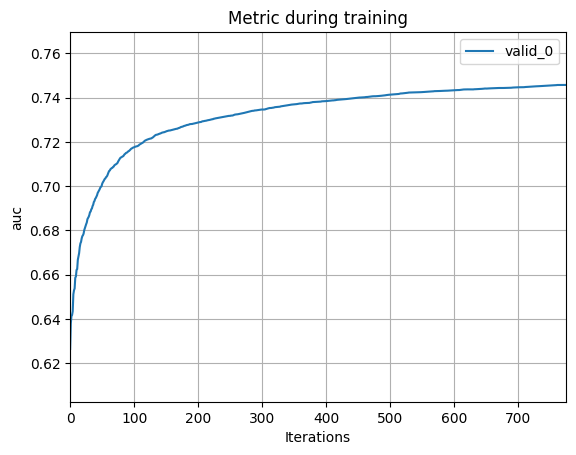

In [44]:
lgb.plot_metric(evals)
print("El mejor valor de AUC fue ", gbm.best_score['valid_0']['auc'], "para el arbol", gbm.best_iteration)

In [45]:
print(f'The AUC score on the train set is: {roc_auc_score(train_data["target"], train_data["score"])}')
print(f'The AUC score on the valid set is: {roc_auc_score(valid_data["target"], valid_data["score"])}')
print(f'The AUC score on the test set is: {roc_auc_score(test_data["target"], test_data["score"])}')

The AUC score on the train set is: 0.7647558361580861
The AUC score on the valid set is: 0.7457594178711751
The AUC score on the test set is: 0.7541589104304902


In [46]:
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()

    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a*x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

stability_score_train = gini_stability(train_data)
stability_score_valid = gini_stability(valid_data)
stability_score_test = gini_stability(test_data)

print(f'The stability score on the train set is: {stability_score_train}')
print(f'The stability score on the valid set is: {stability_score_valid}')
print(f'The stability score on the test set is: {stability_score_test}')

The stability score on the train set is: 0.5041180820280722
The stability score on the valid set is: 0.4477715566725867
The stability score on the test set is: 0.46531836563301116


## Submission

In [47]:
X_submission = data_submission[cols_pred]
X_submission = convert_strings(X_submission)
categorical_cols = X_train.select_dtypes(include=['category']).columns

for col in categorical_cols:
    train_categories = set(X_train[col].cat.categories)
    submission_categories = set(X_submission[col].cat.categories)
    new_categories = submission_categories - train_categories
    X_submission.loc[X_submission[col].isin(new_categories), col] = "Unknown"
    new_dtype = pd.CategoricalDtype(categories=train_categories, ordered=True)
    X_train[col] = X_train[col].astype(new_dtype)
    X_submission[col] = X_submission[col].astype(new_dtype)

y_submission_pred = gbm.predict(X_submission, num_iteration=gbm.best_iteration)

In [48]:
submission = pd.DataFrame({
    "case_id": data_submission["case_id"].to_numpy(),
    "score": y_submission_pred
}).set_index('case_id')
submission.to_csv("./submission.csv")